In [1]:
import re
import os
import cv2
import glob
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"

In [2]:
image_paths = glob.glob(os.getcwd() + '/Test Images/*.jpg') + glob.glob(os.getcwd() + '/Test Images/*.png')

In [3]:
plate_true = []
plate_pred = []

image_grays = []
image_blurs = []
image_edges = []
image_masks = []
image_conts = []
image_crops = []

for file in image_paths:
    
    plate_file = file.split('\\')[-1]
    print("Processing image", plate_file)
    plate_file = os.path.splitext(plate_file)[0]
    plate_true.append(plate_file)
    
    image = cv2.imread(file)
    image_dimy, image_dimx = image.shape[0], image.shape[1]
    image_resz = imagecv2.resize(image, (500, 300))

    filtr_smth = np.ones((3, 3))/9

    image_gray = cv2.cvtColor(image_resz, cv2.COLOR_BGR2GRAY)
    image_blur = cv2.filter2D(image_gray, -1, filtr_smth)
    image_grays.append(image_gray)
    image_blurs.append(image_blur)
    
    image_edge = cv2.Canny(image_blur, 30, 200)
    image_edges.append(image_edge)

    contour, _ = cv2.findContours(image_edge, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contour    = sorted(contour, key=cv2.contourArea, reverse=True)[:10]

    plate_detc = None

    for cont in contour:
        peri = cv2.arcLength(cont, True)
        appr = cv2.approxPolyDP(cont, 0.02 * peri, True)
        if len(appr) == 4:
            plate_detc = appr
            break

    image_mask = np.zeros(image_gray.shape, np.uint8)
    image_cont = cv2.drawContours(image_mask, [plate_detc], 0, 255, -1)
    image_cont = cv2.bitwise_and(image_resz, image_resz, mask=image_mask)
    image_mask = cv2.resize(image_mask, (image_dimx, image_dimy))
    
    image_conts.append(image_cont)
    image_masks.append(image_mask)

    x, y = np.where(image_mask==255)
    t, l = np.min(x)-5, np.min(y)+15 # identify top and left edges of the bounded region with padding
    b, r = np.max(x)+5, np.max(y)-15 # identify bottom and right edges of the bounded region with padding
    
    image_crop = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)[t:b, l:r]
    plate_tess = pytesseract.image_to_string(image_crop)
    plate_tess = plate_tess.strip()
    plate_tess = re.sub(r'[^\w]', '', plate_tess)
    
    if plate_tess == '':
        image_crop = image[t:b, l:r]
        plate_tess = pytesseract.image_to_string(image_crop)
        plate_tess = plate_tess.strip()
        plate_tess = re.sub(r'[^\w]', '', plate_tess)
        
    image_crops.append(image_crop)
    plate_pred.append(plate_tess)

Processing image HWD3092.jpg
Processing image KA555ZG.jpg


error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\imgproc\src\drawing.cpp:2598: error: (-215:Assertion failed) reader.ptr != NULL in function 'cvDrawContours'


In [4]:
plate_true

['HWD3092', 'KA555ZG']

In [5]:
plate_pred

['géfHWD3092']

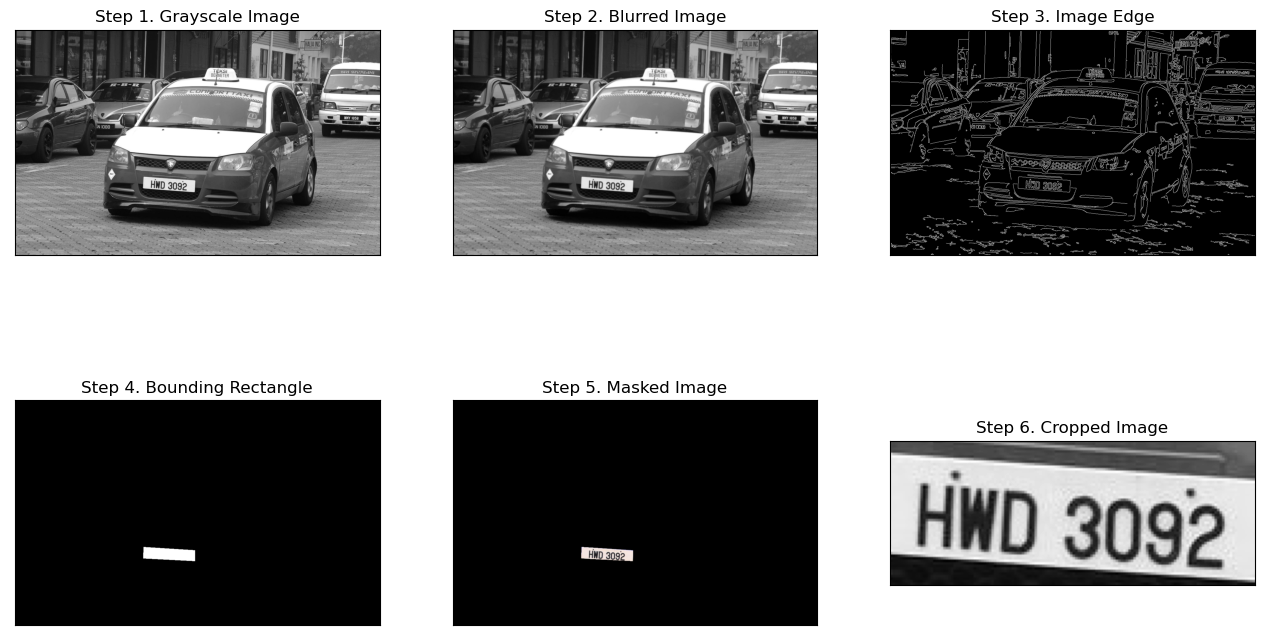

In [6]:
idx = 0

fig, ax = plt.subplots(2, 3, figsize=(16,9), dpi=100)

ax[0,0].imshow(image_grays[idx], cmap='gray');
ax[0,0].axes.xaxis.set_visible(False);
ax[0,0].axes.yaxis.set_visible(False);
ax[0,0].axes.set_title('Step 1. Grayscale Image');

ax[0,1].imshow(image_blurs[idx], cmap='gray');
ax[0,1].axes.xaxis.set_visible(False);
ax[0,1].axes.yaxis.set_visible(False);
ax[0,1].axes.set_title('Step 2. Blurred Image');

ax[0,2].imshow(image_edges[idx], cmap='gray');
ax[0,2].axes.xaxis.set_visible(False);
ax[0,2].axes.yaxis.set_visible(False);
ax[0,2].axes.set_title('Step 3. Image Edge');

ax[1,0].imshow(image_masks[idx], cmap='gray');
ax[1,0].axes.xaxis.set_visible(False);
ax[1,0].axes.yaxis.set_visible(False);
ax[1,0].axes.set_title('Step 4. Bounding Rectangle');

ax[1,1].imshow(image_conts[idx]);
ax[1,1].axes.xaxis.set_visible(False);
ax[1,1].axes.yaxis.set_visible(False);
ax[1,1].axes.set_title('Step 5. Masked Image');

ax[1,2].imshow(image_crops[idx], cmap='gray');
ax[1,2].axes.xaxis.set_visible(False);
ax[1,2].axes.yaxis.set_visible(False);
ax[1,2].axes.set_title('Step 6. Cropped Image');